### Question 3:
Theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability. How would you design and evaluate a computational experiment to test this, at least on the Titanic dataset?

In [42]:
import numpy as np
import pandas as pd
import os
import sklearn
import joblib
import seaborn as sns
from pandas.api.types import is_string_dtype,is_numeric_dtype
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,matthews_corrcoef,f1_score,classification_report,roc_curve,roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [43]:
#Reading data from local
if os.path.isfile("./YongjiShen_Titanic_FullList.csv"):
    my_full_df = pd.read_csv("./YongjiShen_Titanic_FullList.csv")
else:
    print("Not Found")

In [44]:
#Dropping meaningless columns
my_full_df = my_full_df.drop(["PassengerId","Name","Cabin","Ticket"],axis = 1)

In [45]:
my_full_df.shape

(1309, 8)

In [46]:
my_full_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [47]:
my_full_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [48]:
my_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


In [49]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

In [50]:
#split train, validation, and test set
my_train_valid,my_test = mydf_splitter(my_full_df,1100)

my_train_valid.reset_index(inplace = True,drop=True)
my_test.reset_index(inplace = True,drop=True)

print(my_full_df.shape)
print(my_train_valid.shape)
print(my_test.shape)

(1309, 8)
(1100, 8)
(209, 8)


In [51]:
my_train_valid.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         219
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='Count of missing'>

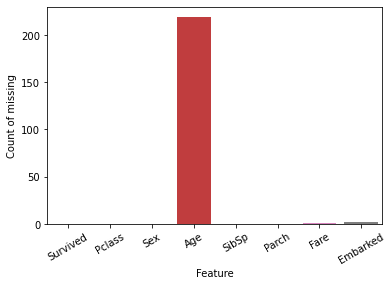

In [52]:
data_df = pd.DataFrame(my_train_valid.isna().sum())
data_df.reset_index(inplace = True)
data_df.columns = ["Feature","Count of missing"]
plt.xticks(rotation=30)
sns.barplot(x = "Feature",y ="Count of missing", data=data_df)

In [53]:
print(my_train_valid.shape)

(1100, 8)


In [54]:
my_train_valid.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         219
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [55]:
my_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1100 non-null   int64  
 1   Pclass    1100 non-null   int64  
 2   Sex       1100 non-null   object 
 3   Age       881 non-null    float64
 4   SibSp     1100 non-null   int64  
 5   Parch     1100 non-null   int64  
 6   Fare      1099 non-null   float64
 7   Embarked  1098 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 68.9+ KB


In [56]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [57]:
my_train_valid = str_to_cat(my_train_valid)

In [58]:
my_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  1100 non-null   int64   
 1   Pclass    1100 non-null   int64   
 2   Sex       1100 non-null   category
 3   Age       881 non-null    float64 
 4   SibSp     1100 non-null   int64   
 5   Parch     1100 non-null   int64   
 6   Fare      1099 non-null   float64 
 7   Embarked  1098 non-null   category
dtypes: category(2), float64(2), int64(4)
memory usage: 54.0 KB


In [59]:
print(my_train_valid.Embarked.cat.categories)
print(my_train_valid.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [60]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [61]:
my_train_valid,my_table= mydf_preprocessor(my_train_valid,null_table = None)

In [62]:
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [63]:
my_train_valid.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,0,3,2,22.0,1,0,7.2500,3,False,False
1,1,1,1,38.0,1,0,71.2833,1,False,False
2,1,3,1,26.0,0,0,7.9250,3,False,False
3,1,1,1,35.0,1,0,53.1000,3,False,False
4,0,3,2,35.0,0,0,8.0500,3,False,False


In [64]:
X_Con = my_train_valid[['Age', 'Fare']]
X_Cat = my_train_valid.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [65]:
X_con_sc.head(2)

,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [66]:
df_list = [X_Cat,X_con_sc]
my_train_valid = pd.concat(df_list,axis=1)
print(my_train_valid.shape)
my_train_valid.head()

(1100, 10)


,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_na,Fare_na,Age,Fare
0,0,3,2,1,0,3,False,False,-0.574896,-0.502155
1,1,1,1,1,0,1,False,False,0.659705,0.747957
2,1,3,1,0,0,3,False,False,-0.266246,-0.488977
3,1,1,1,1,0,3,False,False,0.428217,0.392967
4,0,3,2,0,0,3,False,False,0.428217,-0.486537


In [67]:
y_train_valid = my_train_valid ['Survived']
X_train_valid = my_train_valid .drop(columns=['Survived'],axis=1)
print(X_train_valid.shape,y_train_valid.shape)

(1100, 9) (1100,)


In [68]:
#split train and validation set
X_train,X_valid = mydf_splitter(X_train_valid,900)
y_train,y_valid = mydf_splitter(y_train_valid ,900)
print(X_train.shape,y_train.shape,
      X_valid.shape,y_valid.shape)

(900, 9) (900,) (200, 9) (200,)


In [69]:
#store accuracy for different n_estimators
result_train_valid = dict()

for n in range (1,2001,10):
    mod = RandomForestClassifier(n_jobs = -1, n_estimators = n,
                                 bootstrap = True)
    mod.fit(X_train,y_train)
    y_pred = mod.predict(X_valid)
    result_train_valid[n]=accuracy_score(y_valid,y_pred)

In [70]:
result_df = pd.DataFrame(list(result_train_valid.items()),columns = ['n_estimators', 'accuracy'])

In [71]:
result_df

,n_estimators,accuracy
0,1,0.540
1,11,0.525
2,21,0.545
3,31,0.540
4,41,0.525
...,...,...
195,1951,0.535
196,1961,0.535
197,1971,0.545
198,1981,0.545


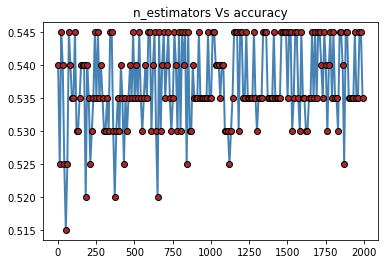

In [72]:
plt.title("n_estimators Vs accuracy")
plt.plot(result_df.n_estimators,result_df.accuracy,linestyle = '-',linewidth = 2, color = 'steelblue',marker = 'o',markersize = 6, markeredgecolor='black', markerfacecolor='brown') 

In [73]:
'''Increasing the number of decision trees (n_estimators), which increasing the chance that model will have better performance'''

'Accuracy '

In [74]:
#Find the best accuracy with train and validation set
sorted_dict = sorted(result_train_valid.items(), key=lambda x: x[1], reverse=True)

In [75]:
sort_result_df = pd.DataFrame(sorted_dict,columns = ['n_estimators', 'accuracy'])

In [76]:
sort_result_df

,n_estimators,accuracy
0,21,0.545
1,71,0.545
2,111,0.545
3,241,0.545
4,261,0.545
...,...,...
195,1871,0.525
196,181,0.520
197,371,0.520
198,651,0.520


In [77]:
#The first list contains the best accuracy with n_estimators
sorted_dict[0]

(21, 0.545)

In [78]:
#Build new model with the best n_estimators
final_mod = RandomForestClassifier(n_jobs = -1, n_estimators = sorted_dict[0][0],
                                 bootstrap = True)

In [79]:
final_mod.fit(X_train_valid,y_train_valid)

RandomForestClassifier(n_estimators=21, n_jobs=-1)

In [80]:
#Data cleaning for test set
my_test.isna().sum()

Survived     0
Pclass       0
Sex          0
Age         44
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='Count of missing'>

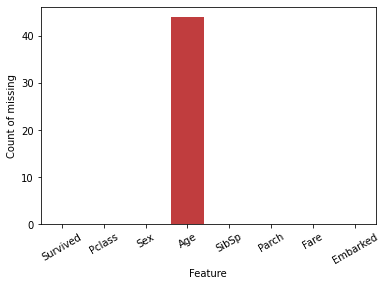

In [81]:
data_df = pd.DataFrame(my_test.isna().sum())
data_df.reset_index(inplace = True)
data_df.columns = ["Feature","Count of missing"]
plt.xticks(rotation=30)
sns.barplot(x = "Feature",y ="Count of missing", data=data_df)

In [82]:
print(my_test.shape)

(209, 8)


In [83]:
my_test.isna().sum()

Survived     0
Pclass       0
Sex          0
Age         44
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64

In [84]:
my_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  209 non-null    int64  
 1   Pclass    209 non-null    int64  
 2   Sex       209 non-null    object 
 3   Age       165 non-null    float64
 4   SibSp     209 non-null    int64  
 5   Parch     209 non-null    int64  
 6   Fare      209 non-null    float64
 7   Embarked  209 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 13.2+ KB


In [85]:
my_test = str_to_cat(my_test)

In [86]:
my_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  209 non-null    int64   
 1   Pclass    209 non-null    int64   
 2   Sex       209 non-null    category
 3   Age       165 non-null    float64 
 4   SibSp     209 non-null    int64   
 5   Parch     209 non-null    int64   
 6   Fare      209 non-null    float64 
 7   Embarked  209 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 10.5 KB


In [87]:
print(my_test.Embarked.cat.categories)
print(my_test.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [88]:
my_test,my_table= mydf_preprocessor(my_test,null_table = my_table)

In [89]:
my_test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,3,2,25.0,0,0,7.8958,3,False,False
1,0,3,2,32.0,0,0,22.5250,3,False,False
2,1,3,2,28.0,0,0,7.0500,3,True,False
3,0,2,2,17.0,0,0,73.5000,3,False,False
4,0,2,1,60.0,1,0,26.0000,3,False,False


In [90]:
X_Con = my_test[['Age', 'Fare']]
X_Cat = my_test.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [91]:
X_con_sc.head(2)

,Age,Fare
0,-0.380034,-0.498006
1,0.176417,-0.228327


In [92]:
df_list = [X_Cat,X_con_sc]
my_test = pd.concat(df_list,axis=1)
print(my_test.shape)
my_test.head()

(209, 10)


,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,2,0,0,3,False,False,-0.380034,-0.498006
1,0,3,2,0,0,3,False,False,0.176417,-0.228327
2,1,3,2,0,0,3,True,False,-0.141555,-0.513598
3,0,2,2,0,0,3,False,False,-1.015978,0.711362
4,0,2,1,1,0,3,False,False,2.402222,-0.164267


In [93]:
y_test = my_test ['Survived']
X_test = my_test .drop(columns=['Survived'],axis=1)
print(X_test.shape,y_test.shape)

(209, 9) (209,)


In [94]:
#Predict target with x_test
y_pred = final_mod.predict(X_test)

In [95]:
#check the accuracy
accuracy_score(y_pred, y_test)

0.5263157894736842

In [96]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.56      0.63       147
           1       0.30      0.44      0.35        62

    accuracy                           0.53       209
   macro avg       0.50      0.50      0.49       209
weighted avg       0.58      0.53      0.55       209



Text(50.99999999999999, 0.5, 'Predicted')

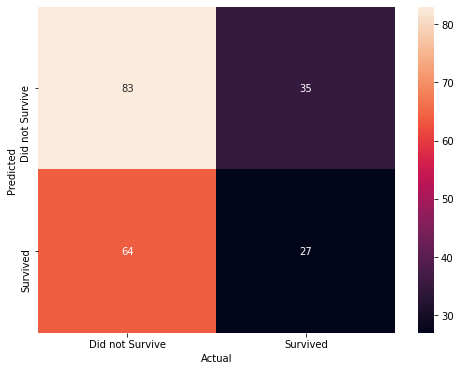

In [97]:
c_mat = confusion_matrix(y_pred, y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

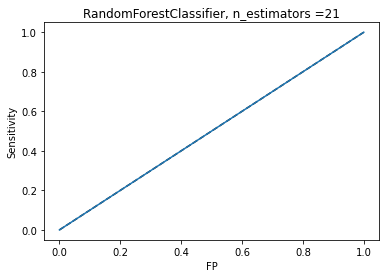

In [98]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
title = "RandomForestClassifier, n_estimators ="+str(sorted_dict[0][0])
plt.title(title)
plt.show()